In [1]:
%load_ext autoreload
%autoreload 2

# ライブラリ

In [2]:
from IPython.display import clear_output

# ライブラリのimportを行います
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import json

import re
import unicodedata
from kanjize import kanji2number
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder


from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import lightgbm as lgb
import logging
logging.getLogger("lightgbm").setLevel(logging.WARNING)
from sklearn.metrics import accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from tqdm.auto import tqdm

# 独自モジュール

In [3]:
import src.preprocess as pre
import src.feature_selection as fs
import src.stacking as stacking
import src.classification_models as models


# Config

In [6]:
np.random.seed(42)
isTune = False

# 提出ファイル作成用

In [ ]:
def make_submitfile(submit_date = "0829",filename = "submission", version = "00", data = []):
    submit = pd.read_csv("data/sample_submit.csv", header=None)
    # 提出ファイルの2列目を予測値で置き換えます。
    submit[1] = data
    submit.to_csv(f"output/{submit_date}{filename}_{version}.csv", index=False, header=None)

## 結果の格納用クラス

In [7]:
class RESULT_class:
    def __init__(self):
        self.RESULT = pd.DataFrame()

    def addResult(self, model_name,
                  feature_selection,
                  under_sampling,
                  PCAd,
                  columns,
                  skf_num,
                  skf_rand,
                  score,
                  oof_valid,
                  oof_test,
                  date = "0829"):

        tmp = pd.DataFrame([[model_name,feature_selection,under_sampling,PCAd,columns,skf_num,skf_rand,score,oof_valid,oof_test,date]])
        tmp.columns = ["model_name","feature_selection","under_sampling","PCA(d)","columns","skf_num","skf_rand","score","oof_valid","oof_test","date"]
        print(len(self.RESULT))
        if len(self.RESULT)>0:
            self.RESULT = pd.concat([self.RESULT, tmp])
        else:
            self.RESULT = tmp

Rc = RESULT_class()

In [8]:
Rc.RESULT

""


# Dataload

In [9]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
train["test"]  = 0
test["test"]  = 1
data = pd.concat([train,test]).reset_index(drop=True)

In [10]:
df_dict = {"data":data}

- id: 営業リストの顧客ID
- Age: 顧客の年齢
- TypeofContact: 顧客への連絡方法
- CityTier: 都市層(1>2>3)
- DurationOfPitch: 営業担当者による顧客への売り込み時間
- Occupation: 顧客のご職業
- Gender: 顧客の性別
- NumberOfPersonVisiting: 一緒に旅行を予定している人数の合計
- NumberOfFollowups: セールストーク後に営業担当者が行ったフォローアップの合計数
- ProductPitched: 営業担当者による商品の売り込み
- PreferredPropertyStar: 顧客によるホテル施設の優先評価
- NumberOfTrips: 顧客の年間旅行数
- Passport: パスポートの所持
- PitchSatisfactionScore: 売り込みの満足度スコア
- Designation: 現在の組織における顧客の指定
- MonthlyIncome: 顧客の月収
- customer_info: 顧客の情報のメモ(婚姻状況や車の有無、旅行の子どもの同伴の有無について記載されている)
- ProdTaken: 目的変数

In [11]:
print(train.shape)
print(test.shape)
print(data.shape)

(3489, 19)
(3489, 18)
(6978, 19)


# 基本変換

In [12]:
# 似た文字のマッピング辞書
char_map = {
    'ς': 'c',
    'а': 'a', 'А': 'A','α':'a',
    'е': 'e', 'Е': 'E',
    'о': 'o', 'О': 'O',
    'с': 'c', 'С': 'C',
    'р': 'p', 'Р': 'P',
    'υ': 'y', 'Υ': 'Y',
    'ꓢ': 'S', 'ꓤ': 'R',
    'Ѕ': 'S','ѕ':'s',
    'Ꭰ': 'D', 'ᗞ': 'D', 'ꭰ': 'D', '𝙳': 'D',
    'Տ': 'S',
    '𝖺': 'a', '𝘤': 'c', '𝔡': 'd',
    '𐊡': 'B', 'в':'B','β':'B',
    'μ':'m',
    'ε':'E',
    'K':'K',
    'ı':'i',
    'n':'n','ո':'n',
    'ｓ': 's', 'տ':'s','ι':'i',
    '×': 'x'
}

# 特定の文字列を正規化するための辞書
pattern_map = {
    r'(?i)basic': 'Basic',
    r'(?i)standard': 'Standard',
    r'(?i)super deluxe': 'Super Deluxe',
    r'(?i)deluxe': 'Deluxe',
    r'(?i)king': 'King',
    r'(?i)de\|uxe': 'Deluxe',
}

In [13]:
for kind in ["data"]:
    df_dict[kind]["Age"] = df_dict[kind]["Age"].map(lambda x:pre.Age(x))
    df_dict[kind]["Age"] = df_dict["data"]["Age"].map(lambda x: pre.age_distribution(df_dict["data"], x) if x < 0 else x)
    df_dict[kind]["DurationOfPitch"] = df_dict[kind]["DurationOfPitch"].map(lambda x:pre.DurationOfPitch(x))
    df_dict[kind]["Gender"] = df_dict[kind]["Gender"].map(lambda x:pre.Gender(x))
    df_dict[kind]["ProductPitched"] = df_dict[kind]["ProductPitched"].map(lambda x:pre.ProductPitched(x, char_map, pattern_map))
    df_dict[kind]["NumberOfTrips"] = df_dict[kind]["NumberOfTrips"].map(lambda x:pre.NumberOfTrips(x))
    df_dict[kind]["Designation"] = df_dict[kind]["Designation"].map(lambda x:pre.ProductPitched(x, char_map, pattern_map))
    df_dict[kind]["MonthlyIncome"] = df_dict[kind]["MonthlyIncome"].map(lambda x:pre.MonthlyIncome(x)).astype(float)
    df_dict[kind]["NumberOfFollowups"] = df_dict[kind]["NumberOfFollowups"].map(lambda x:pre.NumberOfFollowups(x)).astype(float)
    df_dict[kind] = pre.customer_info(df_dict[kind])

In [14]:
df_dict["data"]["MonthlyIncome"] = df_dict["data"]["MonthlyIncome"].map(lambda x: pre.Income_distribution(df_dict["data"], x) if x % 1000 == 0 else x)
df_dict["data"]["MonthlyIncome"] = df_dict["data"]["MonthlyIncome"]/100
df_dict["data"]["MonthlyIncome"] = df_dict["data"]["MonthlyIncome"].round(0)

In [15]:
# カテゴリ変数のリスト
onehotlist = ["Occupation","ProductPitched","Designation","marriage","CityTier"]
labellist = ["Gender", "TypeofContact", "car", "Passport"]
list_cols = onehotlist + labellist

df_dict["data"][list_cols] = df_dict["data"][list_cols].astype('category')


# 欠測補完

In [16]:
import src.Missing_imputation as MI
_train = df_dict["data"].drop(["id","ProdTaken"],axis=1)

for c in ["Age","DurationOfPitch","NumberOfFollowups","NumberOfTrips","MonthlyIncome"]:
    #対象となるデータに欠損がないデータセットの作成
    _tmp = _train.dropna(subset=[c])
    #数値のみを取り出す
    _tmp =_tmp.select_dtypes(include=['number'])
    #数値のみのカラム名を抽出
    colmns = _tmp.columns.tolist()

    #クラスをインスタンス化
    nfill = MI.MissingImputation(c, _tmp)

    nfill.lgb_regression()
    train_result = nfill.pred_lgb(_train[_train[c].isnull()][colmns].drop([c],axis=1))
    
    df_dict["data"].loc[df_dict["data"][c].isnull(), c] = np.round(train_result)


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 5088, number of used features: 9
[LightGBM] [Info] Start training from score 39.247838
Training until validation scores don't improve for 300 rounds
[500]	valid_0's rmse: 8.55111
Early stopping, best iteration is:
[290]	valid_0's rmse: 8.50214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 340
[LightGBM] [Info] Number of data points in the train set: 5044, number of used features: 9
[LightGBM] [Info] Start training from score 14.487906
Training until validation scores don't improve for 300 rounds


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 6.83191
Early stopping, best iteration is:
[212]	valid_0's rmse: 6.77998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 366
[LightGBM] [Info] Number of data points in the train set: 5190, number of used features: 9
[LightGBM] [Info] Start training from score 3.668979
Training until validation scores don't improve for 300 rounds


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 0.807304
Early stopping, best iteration is:
[243]	valid_0's rmse: 0.802753
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 364
[LightGBM] [Info] Number of data points in the train set: 5185, number of used features: 9
[LightGBM] [Info] Start training from score 3.218901
Training until validation scores don't improve for 300 rounds


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 1.67492
Early stopping, best iteration is:
[270]	valid_0's rmse: 1.66422
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 119
[LightGBM] [Info] Number of data points in the train set: 5154, number of used features: 9
[LightGBM] [Info] Start training from score 3642.851572
Training until validation scores don't improve for 300 rounds


C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[500]	valid_0's rmse: 676.747
Early stopping, best iteration is:
[421]	valid_0's rmse: 676.568


# 特徴量作成

## bins

In [17]:
def age_group(Age:float) -> str:
  if Age<=25:
     return 'Youth'
  elif 25<Age<=40:
     return 'Adult'
  elif 40<Age:
     return 'Elderly'

def MonthlyIncome_group(MonthlyIncome:float) -> str:
  if MonthlyIncome <= 2900:
     return 'row'
  elif 290000 <= MonthlyIncome:
     return 'high'

In [18]:
df_dict["data"].insert(3,'AgeGroup',df_dict[kind]['Age'].apply(age_group))
df_dict["data"].insert(3,'MonthlyIncomeGroup',df_dict[kind]['MonthlyIncome'].apply(MonthlyIncome_group))

### 種別内の目的変数割合

In [19]:
def WithinCategoryProbabilities(df, Category_name):
    tmp = df.groupby([Category_name,'ProdTaken'])['id'].count().reset_index(name="TotalCust").merge(df.groupby([Category_name])['id'].count(),on=Category_name)
    tmp=tmp[tmp["ProdTaken"]==1].reset_index(drop="True")
    tmp[f'{Category_name}_ProdTaken_rate']=round(tmp.TotalCust/tmp.id,2)
    return tmp[[Category_name,f"{Category_name}_ProdTaken_rate"]]


df_dict = df_dict.copy()
for category_name in ["MonthlyIncomeGroup","CityTier","Passport","Designation","Occupation","Gender","marriage"]:
    
    df_dict["data"][category_name] = df_dict["data"][category_name].astype("str")
    rate_df = WithinCategoryProbabilities(df_dict["data"], category_name)
    df_dict["data"] = pd.merge(df_dict["data"], rate_df, on = category_name, how = "left")

## 目的変数率

In [20]:
def ProdTaken_rate(df_dict, column):
    tmp = df_dict["data"].groupby([column])["ProdTaken"].sum()/df_dict["train"]["ProdTaken"].sum()
    tmp = tmp.reset_index()
    tmp.columns = [column, f"ProdTaken_{column}Rate"]
    
    df_dict["data"] = pd.merge(df_dict["data"], tmp, on = column, how = "left")
    
    return df_dict
df_dict = ProdTaken_rate(df_dict, "MonthlyIncomeGroup")
df_dict = ProdTaken_rate(df_dict, "TypeofContact")
df_dict = ProdTaken_rate(df_dict, "CityTier")
df_dict = ProdTaken_rate(df_dict, "Occupation")
df_dict = ProdTaken_rate(df_dict, "Gender")
df_dict = ProdTaken_rate(df_dict, "ProductPitched")
df_dict = ProdTaken_rate(df_dict, "PreferredPropertyStar")
df_dict = ProdTaken_rate(df_dict, "PitchSatisfactionScore")
df_dict = ProdTaken_rate(df_dict, "Designation")


C:\Users\ctiha\AppData\Local\Temp\ipykernel_21712\4100086650.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df_dict["data"].groupby([column])["ProdTaken"].sum()/df_dict["train"]["ProdTaken"].sum()
C:\Users\ctiha\AppData\Local\Temp\ipykernel_21712\4100086650.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df_dict["data"].groupby([column])["ProdTaken"].sum()/df_dict["train"]["ProdTaken"].sum()


## カテゴリ変数エンコーディング

In [21]:
# カテゴリ変数のリスト
onehotlist = ["AgeGroup","MonthlyIncomeGroup","Occupation","ProductPitched","Designation","marriage","CityTier"]
labellist = ["Gender","TypeofContact","car","Passport"]
list_cols = onehotlist + labellist

### Target encoding

In [22]:
for c in list_cols:
    df_dict = df_dict.copy()
    groupby_tmp = df_dict["data"].groupby(c)["MonthlyIncome"].agg(["mean", "var"]).reset_index()
    groupby_tmp.columns = [c, f"{c}_mean", f"{c}_var"]
    
    df_dict["data"] = pd.merge(df_dict["data"],groupby_tmp, on = c,how="left")

C:\Users\ctiha\AppData\Local\Temp\ipykernel_21712\1136530661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupby_tmp = df_dict["data"].groupby(c)["MonthlyIncome"].agg(["mean", "var"]).reset_index()
C:\Users\ctiha\AppData\Local\Temp\ipykernel_21712\1136530661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupby_tmp = df_dict["data"].groupby(c)["MonthlyIncome"].agg(["mean", "var"]).reset_index()
C:\Users\ctiha\AppData\Local\Temp\ipykernel_21712\1136530661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False

## 数値変換

In [23]:
# NumberOfFollowups / DurationOfPitch: フォローアップの効率性
df_dict["data"]['Followup_Efficiency'] = df_dict["data"]['NumberOfFollowups'] / df_dict["data"]['DurationOfPitch']

city_income_level = df_dict["data"].groupby('CityTier')['MonthlyIncome'].mean().to_dict()
df_dict["data"]['city_income_level'] = df_dict["data"]['CityTier'].map(city_income_level)

In [24]:
CityTier_Designation_Income = df_dict["data"].groupby(['CityTier',"Designation"])['MonthlyIncome'].mean().reset_index()
CityTier_Designation_Income.columns = ["CityTier","Designation","CityTier_Designation_Income"]
df_dict["data"] = pd.merge(df_dict["data"],CityTier_Designation_Income, on = ['CityTier',"Designation"], how = "left")

In [25]:
tmp = df_dict["data"].groupby(["Passport","NumberOfTrips"],observed=False).count()["id"].reset_index()
tmp = tmp.rename(columns={'id': 'Passport_NumberOfTrips'}).copy()
df_dict["data"] = pd.merge(df_dict["data"],tmp,how = "left")


tmp = df_dict["data"].groupby(["Passport","Gender"],observed=False).count()["id"].reset_index()
tmp = tmp.rename(columns={'id': 'Passport_Gender'})
df_dict["data"] = pd.merge(df_dict["data"],tmp,how = "left")

# ラベルエンコーディング

In [26]:
onehotlist = ["MonthlyIncomeGroup","AgeGroup","Occupation","ProductPitched","Designation","marriage","CityTier"]
labellist = ["Gender", "TypeofContact", "car", "Passport"]
list_cols = onehotlist + labellist

In [27]:
df_dict["data"][list_cols] = df_dict["data"][list_cols].astype("str")
for c in list_cols:
    le = LabelEncoder()
    le.fit(df_dict["data"][c].values)
    df_dict["data"][c] = le.transform(df_dict["data"][c].values)

# データ傾向

C:\Users\ctiha\AppData\Local\Programs\Python\Python311\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


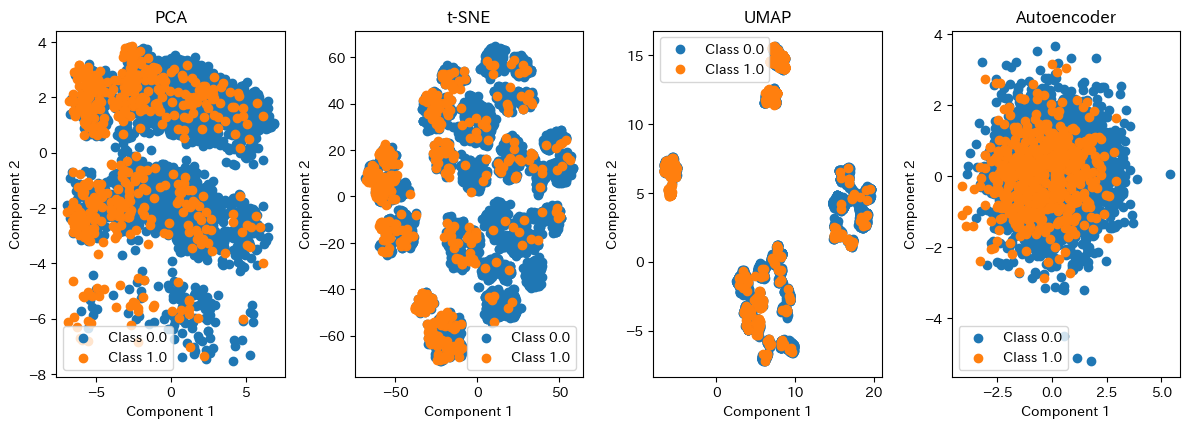

In [28]:
import src.DimensionalityReduction as dr
from sklearn.preprocessing import StandardScaler
y    = df_dict["data"].dropna()["ProdTaken"]
X    = df_dict["data"].dropna().drop(columns=['id', 'customer_info',"ProdTaken"], axis=1)#.astype(float)
X = X.drop(onehotlist,axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
DR = dr.DimensionalityReduction(X_scaled,y.values)
DR.view()

# Training Phase

## 学習用データ

In [29]:
train = df_dict["data"][df_dict["data"]["test"] == 0].drop("test",axis=1)
test = df_dict["data"][df_dict["data"]["test"] == 1].drop("test",axis=1)
# "ProdTaken"は予測対象とするため、別途target変数に格納する
y    = train["ProdTaken"]
X    = train.drop(columns=['id', 'customer_info',"ProdTaken"], axis=1)
test = test.drop(columns=['id', 'customer_info',"ProdTaken"], axis=1)

## Turning

In [30]:
import src.classification_models as models
lgb_class = models.Classification_models(NUM_CLASS = 2, random_seed = 0, isOversampling = False, categorical_columns = list_cols)
xgb_class = models.Classification_models(NUM_CLASS = 2, random_seed = 0, isOversampling = False, categorical_columns = list_cols)
cat_class = models.Classification_models(NUM_CLASS = 2, random_seed = 0, isOversampling = False, categorical_columns = list_cols)
if isTune:
    lgb_class.lgb_tune(X, y)
    xgb_class.xgb_tune(X, y)
    cat_class.cat_tune(X, y)

## running test

## Stacking lightGBM

In [31]:
def StackingLightGBM(X, y, test, N_SPLITS = 3, MAX_NUM = 100, feature_selection= False, under_sampling = False, PCAd = False):
    if PCAd:
        columns = []
        X = pd.DataFrame(X)
        test = pd.DataFrame(test)
    else:
        columns = X.columns.tolist()
    for i in tqdm(range(MAX_NUM)):
        lgb_stacking = stacking.Stacking(lgb_class.lgb_train,
                                         lgb_class.lgb_pred,
                                         N_SPLITS = N_SPLITS,
                                         NUM_CLASSES = 2,
                                         isSave = False,
                                         save_dir = "model",
                                         model_name = "lgb",
                                         random_seed = i)
        oof_valid, oof_test = lgb_stacking.classification(X, y, test)
        score = roc_auc_score(y, oof_valid)
        clear_output(True)
        Rc.addResult("lightGBM",  feature_selection, under_sampling, PCAd, columns, N_SPLITS, i, score, oof_valid, oof_test)
StackingLightGBM(X,         y, test    , N_SPLITS = 3, MAX_NUM = 100, feature_selection=False, under_sampling = False, PCAd = False)
StackingLightGBM(X,         y, test    , N_SPLITS = 5, MAX_NUM = 100, feature_selection=False, under_sampling = False, PCAd = False)

146
[CV] 1/5
Fold 1 AUC: 0.851128762541806
[CV] 2/5


KeyboardInterrupt: 

## Stacking XGBoost

In [ ]:
def StackingXGBoost(X, y, test, N_SPLITS = 3, MAX_NUM = 100, feature_selection= False, under_sampling = False, PCAd = False):
    if PCAd:
        columns = []
        X = pd.DataFrame(X)
        test = pd.DataFrame(test)
    else:
        columns = X.columns.tolist()
    for i in tqdm(range(MAX_NUM)):
        xgb_stacking = stacking.Stacking(xgb_class.xgb_train,
                                         xgb_class.xgb_pred,
                                         N_SPLITS = N_SPLITS,
                                         NUM_CLASSES = 2,
                                         isSave = True,
                                         save_dir = "model",
                                         model_name = "xgb",
                                         random_seed = i)
        oof_valid, oof_test = xgb_stacking.classification(X, y, test)

        score = roc_auc_score(y, oof_valid)
        clear_output(True)
        Rc.addResult("XGBoost",  feature_selection, under_sampling, PCAd, columns, N_SPLITS, i, score, oof_valid, oof_test)
StackingXGBoost(X,         y, test    , N_SPLITS = 3, MAX_NUM = 100, feature_selection=False, under_sampling = False, PCAd = False)
StackingXGBoost(X,         y, test    , N_SPLITS = 5, MAX_NUM = 100, feature_selection=False, under_sampling = False, PCAd = False)

## Stacking Catboost

In [ ]:
def StackingCatBoost(X, y, test, N_SPLITS = 3, MAX_NUM = 100, feature_selection= False, under_sampling = False, PCAd = False):
    if PCAd:
        columns = []
        X = pd.DataFrame(X)
        test = pd.DataFrame(test)
    else:
        columns = X.columns.tolist()
    for i in tqdm(range(MAX_NUM)):
        cat_stacking = stacking.Stacking(cat_class.cat_train,
                                         cat_class.cat_pred,
                                         N_SPLITS = N_SPLITS,
                                         NUM_CLASSES = 2,
                                         isSave = True,
                                         save_dir = "model",
                                         model_name = "cat",
                                         random_seed = i)
        oof_valid, oof_test = cat_stacking.classification(X, y, test)

        score = roc_auc_score(y, oof_valid)
        clear_output(True)
        Rc.addResult("CatBoost",  feature_selection, under_sampling, PCAd, columns, N_SPLITS, i, score, oof_valid, oof_test)

StackingCatBoost(X,         y, test    , N_SPLITS = 3, MAX_NUM = 100, feature_selection=False, under_sampling = False, PCAd = False)
StackingCatBoost(X,         y, test    , N_SPLITS = 5, MAX_NUM = 100, feature_selection=False, under_sampling = False, PCAd = False)

# Stacking Tabpfn

In [ ]:
import src.classification_tabpfn as tabpfn
def StackingTabpfn(X, y, test, N_SPLITS = 3, MAX_NUM = 100, feature_selection= False, under_sampling = False, PCAd = False):
    for i in range(MAX_NUM):
        tabpfn_stacking = tabpfn.CustomStacking(N_SPLITS = N_SPLITS,
                                             N_ensemble_configurations = 32,
                                         isSave = False,
                                         save_dir = "model",
                                         random_seed = i)
        oof_valid_tabpfn, oof_test_tabpfn = tabpfn_stacking.classification(X, y, test)
        clear_output(True)
        
        score = roc_auc_score(y, oof_valid_tabpfn)
        clear_output(True)
        Rc.addResult("tabpfn",  False, False, False, X.columns.tolist(), N_SPLITS, i, score, oof_valid_tabpfn, oof_test_tabpfn)
        print(score)
StackingTabpfn(X,         y, test    , N_SPLITS = 5, MAX_NUM = 100, feature_selection=False, under_sampling = False, PCAd = False)
StackingTabpfn(X,         y, test    , N_SPLITS = 10, MAX_NUM = 100, feature_selection=False, under_sampling = False, PCAd = False)

# 評価

In [ ]:
from sklearn.metrics import roc_curve

plt.plot([0, 1], [0, 1], 'k--')
for oof in Rc.RESULT.oof_valid:
    fpr, tpr, thresholds = roc_curve(y, oof)
    plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [ ]:
for model_name in ["lightGBM","XGBoost","CatBoost","tabpfn"]:
    tmp = Rc.RESULT[Rc.RESULT.model_name == model_name]
    tmp = tmp[tmp["score"] > 0.83]
    #tmp = tmp[tmp["PCA(d)"] == 0]
    score = roc_auc_score(y, tmp.oof_valid.mean())

    print(model_name, score)

In [ ]:
tmp = Rc.RESULT.copy()
tmp = tmp[tmp["score"] > 0.83]
score = roc_auc_score(y, tmp.oof_valid.mean())
print("merge", score)

In [ ]:
oof_test_merge = tmp.oof_test.mean()

In [ ]:
make_submitfile(submit_date = "0831",filename = f"submission_merge", version = "01", data = oof_test_merge)

## stacking

In [ ]:
 tmp.reset_index().oof_valid.values[i]

In [ ]:
tmp = Rc.RESULT.copy()
tmp = tmp[tmp["score"] > 0.83]

stack_train = pd.DataFrame()
stack_test = pd.DataFrame()
for i in range(len(tmp)):
    stack_train[str(i).zfill(3)] = tmp.reset_index().oof_valid.iloc[i]
    stack_test[str(i).zfill(3)] = tmp.reset_index().oof_test.iloc[i]

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42) # ロジスティック回帰モデルのインスタンスを作成
lr.fit(stack_train, y) # ロジスティック回帰モデルの重みを学習

In [ ]:
y_train_pred = lr.predict_proba(stack_train)[:,1]
y_test_pred = lr.predict_proba(stack_test)[:,1]
score = roc_auc_score(y, y_train_pred)
print(score)

In [ ]:
make_submitfile(submit_date = "0831",filename = f"submission_stacking", version = "01", data = y_test_pred)

In [ ]:
from sklearn.metrics import roc_curve

plt.plot([0, 1], [0, 1], 'k--')
for oof in Rc.RESULT.oof_valid:
    fpr, tpr, thresholds = roc_curve(y, oof)
    plt.plot(fpr,tpr,label='LogisticRegression')
fpr, tpr, thresholds = roc_curve(y, y_train_pred)
plt.plot(fpr,tpr,label='LogisticRegression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()